## Entendendo o problema



Objetivo: Previsão do primeiro destino que um novo usuário irá escolher

Modelo de negócio airbnb: Marketplace

    * Oferta:

        * Tamanho do portifolio
        * Diversidade/Densidade do portifolio
        * Preco médio 

    * Demanda
    
        * Numero de usuários
        * LTV (Lifetime value - quanto espero ganhar com o cliente (ticket médio))
        * CAC (Client Acquistion Coust)

    * Receita
        fee = Preco médio - repasse
        * Gross Revenue ( Margens de contribuição ) = (fee * Numero de clientes) - cac  

In [1]:
import pandas as pd
import numpy as np
path_data = '../../DATA/'


## Exploração e tratamentos iniciais

### train_users

In [2]:
train_users = pd.read_csv(path_data + 'train_users_2.csv', parse_dates=['timestamp_first_active'])
display(train_users.sample(10))
print('Registros: {}'.format(len(train_users)))


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
46694,f7yabu1nyi,2012-10-30,2012-10-30 17:59:20,2012-11-08,-unknown-,38.0,basic,12,en,api,other,untracked,iOS,iPhone,-unknown-,US
15444,0w66xlfsq6,2012-01-18,2012-01-18 07:54:49,2012-02-08,FEMALE,33.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,US
68846,xeqii1hf3j,2013-04-03,2013-04-03 17:42:17,2014-01-18,MALE,33.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari,US
74829,jfhoeu2pg0,2013-05-04,2013-05-04 14:26:35,2013-05-11,MALE,37.0,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,US
58947,fbn2j1y84t,2013-02-04,2013-02-04 20:25:25,NaN,-unknown-,NaN,basic,0,en,other,padmapper,untracked,Web,Mac Desktop,Chrome,NDF
9905,g9sj893kv8,2011-09-21,2011-09-21 18:16:12,2011-11-22,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Mac Desktop,Firefox,FR
184618,yiywyoyazq,2014-05-05,2014-05-05 03:20:35,2014-05-05,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,US
110410,ujuj7quk7h,2013-09-23,2013-09-23 21:49:13,NaN,-unknown-,NaN,basic,0,en,direct,direct,tracked-other,Web,Mac Desktop,Safari,NDF
49149,zz2wuh9npk,2012-11-19,2012-11-19 18:20:30,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF
128065,bmjqzkfztz,2013-11-27,2013-11-27 19:58:47,2013-11-28,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US


Registros: 213451


In [3]:
train_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  object        
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   object        
 4   gender                   213451 non-null  object        
 5   age                      125461 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [4]:
# Avaliando qualidade do campo date_first_booking e coutry_destination
len(train_users[train_users['country_destination'] == 'NDF']) - train_users.date_first_booking.isna().sum()


0

**Todos os date_first_booking NaN representam um country NDF, ou seja sem booking.**

Analisando country destination

<Axes: >

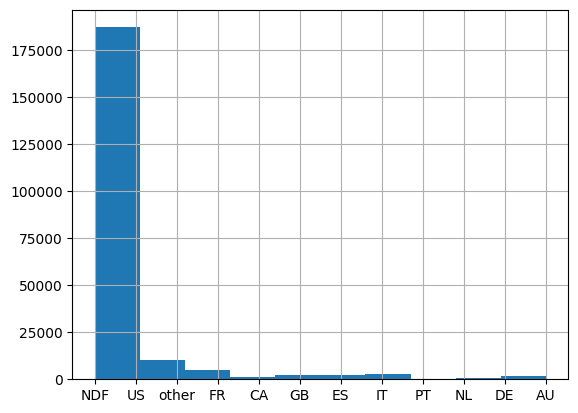

In [6]:
train_users.country_destination.hist()

### test_users

In [15]:
test_users = pd.read_csv(path_data + 'test_users.csv', parse_dates=['timestamp_first_active'])
display(test_users.sample(10))
print('Registros: {}'.format(len(test_users)))


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
37506,o1msnibea4,2014-08-23,2014-08-23 20:40:33,NaN,-unknown-,36.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
38693,8ujz42wfon,2014-08-25,2014-08-25 18:30:21,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,iPhone,Mobile Safari
47774,wwxqccjz3l,2014-09-08,2014-09-08 01:29:41,NaN,MALE,46.0,facebook,0,en,seo,facebook,product,Web,Windows Desktop,Chrome
23675,rwn9hxzwzb,2014-08-04,2014-08-04 01:34:31,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-
38250,oy37quaezb,2014-08-25,2014-08-25 00:21:41,NaN,FEMALE,31.0,facebook,0,en,direct,direct,linked,Web,Mac Desktop,Safari
21991,eklm5v1bc8,2014-08-01,2014-08-01 07:52:39,NaN,FEMALE,29.0,facebook,25,en,direct,direct,untracked,iOS,iPhone,-unknown-
32679,pkv1vfb81y,2014-08-16,2014-08-16 15:00:59,NaN,FEMALE,30.0,facebook,0,en,direct,direct,linked,Web,Desktop (Other),Chrome
52778,9fv9vhqrwz,2014-09-15,2014-09-15 23:22:55,NaN,FEMALE,20.0,facebook,0,es,sem-non-brand,google,linked,Web,Windows Desktop,Chrome
57214,7wktqs2aux,2014-09-23,2014-09-23 01:34:23,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Moweb,iPhone,Mobile Safari
28971,116nkkssxs,2014-08-11,2014-08-11 07:17:10,NaN,MALE,24.0,facebook,25,en,direct,direct,untracked,iOS,iPhone,-unknown-


Registros: 62096


In [16]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       62096 non-null  object        
 1   date_account_created     62096 non-null  object        
 2   timestamp_first_active   62096 non-null  datetime64[ns]
 3   date_first_booking       0 non-null      float64       
 4   gender                   62096 non-null  object        
 5   age                      33220 non-null  float64       
 6   signup_method            62096 non-null  object        
 7   signup_flow              62096 non-null  int64         
 8   language                 62096 non-null  object        
 9   affiliate_channel        62096 non-null  object        
 10  affiliate_provider       62096 non-null  object        
 11  first_affiliate_tracked  62076 non-null  object        
 12  signup_app               62096 n

**DATE_FIRST_BOOKING** aos valores nulos consideraremos casos em que os usuário não realizaram "booking" até a coleta dos dados, o que até faz sentido quando deseja-se realmente prever será o booking country

### sessions

In [38]:
sessions = pd.read_csv(path_data + 'sessions.csv')
display(test_users.sample(10))
print('Registros: {}'.format(len(sessions)))


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
3715,bvhkyrek3h,2014-07-07,2014-07-07 21:20:03,NaN,MALE,32.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Chrome
53262,v3syc81h6e,2014-09-16,2014-09-16 17:42:57,NaN,-unknown-,47.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
35179,os0gep350z,2014-08-20,2014-08-20 04:22:00,NaN,-unknown-,32.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari
42364,bzcbe04zq9,2014-08-30,2014-08-30 15:17:08,NaN,-unknown-,NaN,basic,25,zh,direct,direct,untracked,iOS,iPhone,-unknown-
41479,on7jk7qdfb,2014-08-29,2014-08-29 00:53:00,NaN,-unknown-,NaN,basic,25,en,direct,direct,linked,iOS,iPhone,Mobile Safari
27563,dd71l2a455,2014-08-09,2014-08-09 04:58:46,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-
21755,gelfl6ru5i,2014-08-01,2014-08-01 01:34:47,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox
51750,tgmyaevh23,2014-09-14,2014-09-14 04:42:07,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Moweb,iPhone,Mobile Safari
6282,5jpoqudki5,2014-07-12,2014-07-12 01:43:48,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari
56929,0hj6ahe2t5,2014-09-22,2014-09-22 18:26:37,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


Registros: 10567737


In [27]:
registros = len(sessions)
for c in sessions.columns:
    nan = sessions[c].isna().sum()
    print('{} : {} --> {} %'.format(c, nan, round((nan/registros)*100),2))


user_id : 34496 --> 0 %
action : 79626 --> 1 %
action_type : 1126204 --> 11 %
action_detail : 1126204 --> 11 %
device_type : 0 --> 0 %
secs_elapsed : 136031 --> 1 %


### Countries

In [34]:
countries = pd.read_csv(path_data + 'countries.csv')
display(countries.sample(10))
print('Registros: {}'.format(len(countries)))


,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


Registros: 10


### Age_gender

In [33]:
age_gender = pd.read_csv(path_data + 'age_gender_bkts.csv')
display(age_gender.sample(10))
print('Registros: {}'.format(len(age_gender)))


,age_bucket,country_destination,gender,population_in_thousands,year
214,10-14,GB,male,1771.0,2015.0
323,15-19,NL,female,484.0,2015.0
250,90-94,GB,male,145.0,2015.0
67,15-19,CA,male,1054.0,2015.0
42,75-79,CA,female,530.0,2015.0
229,35-39,GB,female,1964.0,2015.0
280,80-84,IT,female,1231.0,2015.0
159,100+,ES,female,9.0,2015.0
358,100+,PT,male,0.0,2015.0
76,5-9,CA,female,960.0,2015.0


Registros: 420


In [35]:
age_gender.country_destination.value_counts()

country_destination
AU    42
CA    42
DE    42
ES    42
FR    42
GB    42
IT    42
NL    42
PT    42
US    42
Name: count, dtype: int64

In [36]:
age_gender.age_bucket.value_counts()

age_bucket
100+     20
45-49    20
5-9      20
10-14    20
15-19    20
20-24    20
25-29    20
30-34    20
35-39    20
40-44    20
50-54    20
95-99    20
55-59    20
60-64    20
65-69    20
70-74    20
75-79    20
80-84    20
85-89    20
90-94    20
0-4      20
Name: count, dtype: int64

In [37]:
age_gender.population_in_thousands.isna().sum()

0